# Análisis del Algoritmo de Strassen

Este notebook ejecuta y analiza el rendimiento del algoritmo de Strassen para multiplicación de matrices, comparando tiempos medidos con el tiempo teórico esperado $ O(n^{\log_2 7}) \approx O(n^{2.807}) $.

Se extraen resultados del script `strassen_pure_labels.py`, se ajusta un modelo teórico mediante regresión, y se generan gráficas y tablas para el análisis.

In [1]:
import subprocess
import re
import numpy as np
import matplotlib.pyplot as plt
import sys

## 1. Ejecutar el experimento original

In [2]:
def run_original_experiment():
    """Ejecuta el código original y captura sus resultados"""
    print("Ejecutando experimento original (sin modificaciones)...")
    result = subprocess.run(
        [sys.executable, "strassen_pure_labels.py"],
        capture_output=True,
        text=True
    )
    
    if result.returncode != 0:
        print("Error al ejecutar el experimento:")
        print(result.stderr)
        sys.exit(1)
    
    # Extraer resultados con regex
    pattern = r"Tamaño (\d+): ([\d.]+) segundos"
    matches = re.findall(pattern, result.stdout)
    
    if not matches:
        print("No se encontraron resultados en la salida. Verifica el formato de impresión.")
        sys.exit(1)
    
    sizes = [int(m[0]) for m in matches]
    times = [float(m[1]) for m in matches]
    
    print("\nResultados capturados:")
    for n, t in zip(sizes, times):
        print(f"  n = {n}: {t:.6f} s")
    
    return sizes, times

## 2. Calcular tiempo teórico y overhead

In [3]:
def calculate_theoretical_time(sizes, times_measured):
    """Calcula tiempo teórico y overhead usando mínimos cuadrados"""
    exponent = np.log2(7)  # ≈ 2.807
    
    # Convertir a logaritmos
    log_sizes = np.log(sizes)
    log_times = np.log(times_measured)
    
    # Calcular constante 'c' con regresión lineal (pendiente fija en 2.807)
    log_c = np.mean(log_times - exponent * log_sizes)
    c = np.exp(log_c)
    
    # Tiempo teórico
    times_theoretical = c * (np.array(sizes) ** exponent)
    
    # Overhead
    overhead = np.array(times_measured) / times_theoretical
    
    return c, times_theoretical, overhead

## 3. Mostrar tabla de resultados

In [4]:
def print_results_table(sizes, times_measured, times_theoretical, overhead):
    """Imprime tabla de resultados formateada"""
    print("\n" + "="*60)
    print(f"{'RESULTADOS DEL EXPERIMENTO':^60}")
    print("="*60)
    print(f"{'n':<8}{'Medido (s)':<15}{'Teórico (s)':<15}{'Overhead':<10}{'% Error':<10}")
    print("-"*60)
    
    for i in range(len(sizes)):
        error_pct = (overhead[i] - 1) * 100
        print(f"{sizes[i]:<8}{times_measured[i]:<15.6f}{times_theoretical[i]:<15.6f}"
              f"{overhead[i]:<10.2f}{error_pct:<10.1f}%")
    
    print("-"*60)
    print(f"{'PROMEDIO':<8}{'':<15}{'':<15}{np.mean(overhead):<10.2f}"
          f"{np.mean(np.abs(overhead - 1)) * 100:<10.1f}%")
    print("="*60)

## 4. Generar gráficas de análisis

In [5]:
def plot_analysis(sizes, times_measured, times_theoretical, overhead):
    """Genera gráficas de análisis"""
    plt.figure(figsize=(15, 10))
    
    # Gráfica 1: Tiempos medidos vs teóricos (escala lineal)
    plt.subplot(2, 2, 1)
    plt.plot(sizes, times_measured, 'o-', label='Medido', color='tab:blue')
    plt.plot(sizes, times_theoretical, 's--', label='Teórico', color='tab:red')
    
    for n, t in zip(sizes, times_measured):
        plt.text(n, t, f'{n}', ha='center', va='bottom')
    
    plt.title('Tiempos: Medido vs Teórico (Escala Lineal)')
    plt.xlabel('Tamaño n')
    plt.ylabel('Tiempo (s)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Gráfica 2: Escala log-log para verificar complejidad
    plt.subplot(2, 2, 2)
    plt.loglog(sizes, times_measured, 'o-', base=2, label='Medido', color='tab:blue')
    
    # Línea de referencia para O(n^2.807)
    n_fit = np.logspace(np.log2(min(sizes)), np.log2(max(sizes)), 50, base=2)
    plt.loglog(n_fit, times_theoretical[0] * (n_fit/sizes[0])**np.log2(7), 
               'r--', label=r'O($n^{2.807}$)')
    
    # Línea de referencia para O(n^3)
    plt.loglog(n_fit, times_theoretical[0] * (n_fit/sizes[0])**3, 
               'g:', label=r'O($n^3$)')
    
    for n, t in zip(sizes, times_measured):
        plt.text(n, t, f'{n}', ha='center', va='bottom')
    
    plt.title('Análisis de Complejidad (Escala Log-Log)')
    plt.xlabel('Tamaño n (log scale)')
    plt.ylabel('Tiempo (s) (log scale)')
    plt.grid(True, which="both", ls="-", alpha=0.7)
    plt.legend()
    
    # Calcular pendiente real
    log_sizes = np.log2(sizes)
    log_times = np.log2(times_measured)
    slope = np.polyfit(log_sizes[1:], log_times[1:], 1)[0]  # Ignorar n=2 si es ruidoso
    
    plt.annotate(f'Pendiente medida: {slope:.3f}\nTeórica: 2.807', 
                 xy=(0.05, 0.15), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Gráfica 3: Overhead
    plt.subplot(2, 2, 3)
    plt.plot(sizes, overhead, 'o-', color='tab:purple')
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7)
    
    for n, oh in zip(sizes, overhead):
        plt.text(n, oh, f'{oh:.2f}', ha='center', va='bottom')
    
    plt.title('Overhead (Tiempo Medido / Tiempo Teórico)')
    plt.xlabel('Tamaño n')
    plt.ylabel('Overhead')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Gráfica 4: % Error
    plt.subplot(2, 2, 4)
    error_pct = (overhead - 1) * 100
    plt.bar(sizes, error_pct, color=['tab:green' if e <= 0 else 'tab:red' for e in error_pct])
    
    for n, e in zip(sizes, error_pct):
        plt.text(n, e + (1 if e >= 0 else -3), f'{e:.1f}%', ha='center')
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.title('Error Relativo vs. Tiempo Teórico')
    plt.xlabel('Tamaño n')
    plt.ylabel('Error (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('strassen_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✅ Gráficas guardadas en 'strassen_analysis.png'")
    plt.show()

## 5. Ejecución principal

In [6]:
def main():
    # 1. Ejecutar experimento original
    sizes, times_measured = run_original_experiment()
    
    # 2. Calcular tiempo teórico y overhead
    c, times_theoretical, overhead = calculate_theoretical_time(sizes, times_measured)
    
    # 3. Mostrar tabla de resultados
    print_results_table(sizes, times_measured, times_theoretical, overhead)
    
    # 4. Generar gráficas
    plot_analysis(sizes, times_measured, times_theoretical, overhead)
    
    # 5. Análisis final
    print("\n" + "="*60)
    print("ANÁLISIS FINAL")
    print("="*60)
    print(f"- Constante de proporcionalidad (c): {c:.2e}")
    print(f"- Pendiente medida en escala log-log: {np.polyfit(np.log2(sizes)[1:], np.log2(times_measured)[1:], 1)[0]:.3f}")
    print(f"- Overhead promedio: {np.mean(overhead):.2f}x")
    print(f"- Tiempo teórico para n=1024: {c * (1024**np.log2(7)):.4f} s")
    
    if np.mean(overhead) > 3.0:
        print("\n⚠️  ADVERTENCIA: Overhead muy alto. Strassen puro no es práctico en Python para estos tamaños.")
        print("   Considera añadir un umbral de recursión (ej.: usar algoritmo tradicional para n < 64).")
    else:
        print("\n✅ El algoritmo se acerca a su complejidad teórica para los tamaños medidos.")

Ejecutando experimento original (sin modificaciones)...

Resultados capturados:
  n = 2: 0.000090 s
  n = 4: 0.000430 s
  n = 8: 0.001880 s
  n = 16: 0.010520 s
  n = 32: 0.077230 s
  n = 64: 0.546860 s

                 RESULTADOS DEL EXPERIMENTO                 
n       Medido (s)     Teórico (s)    Overhead  % Error   
------------------------------------------------------------
2       0.000090       0.000044       2.07      106.7     %
4       0.000430       0.000305       1.41      41.1      %
8       0.001880       0.002133       0.88      -11.9     %
16      0.010520       0.014933       0.70      -29.6     %
32      0.077230       0.104529       0.74      -26.1     %
64      0.546860       0.731705       0.75      -25.3     %
------------------------------------------------------------
PROMEDIO                              1.09      40.1      %

✅ Gráficas guardadas en 'strassen_analysis.png'


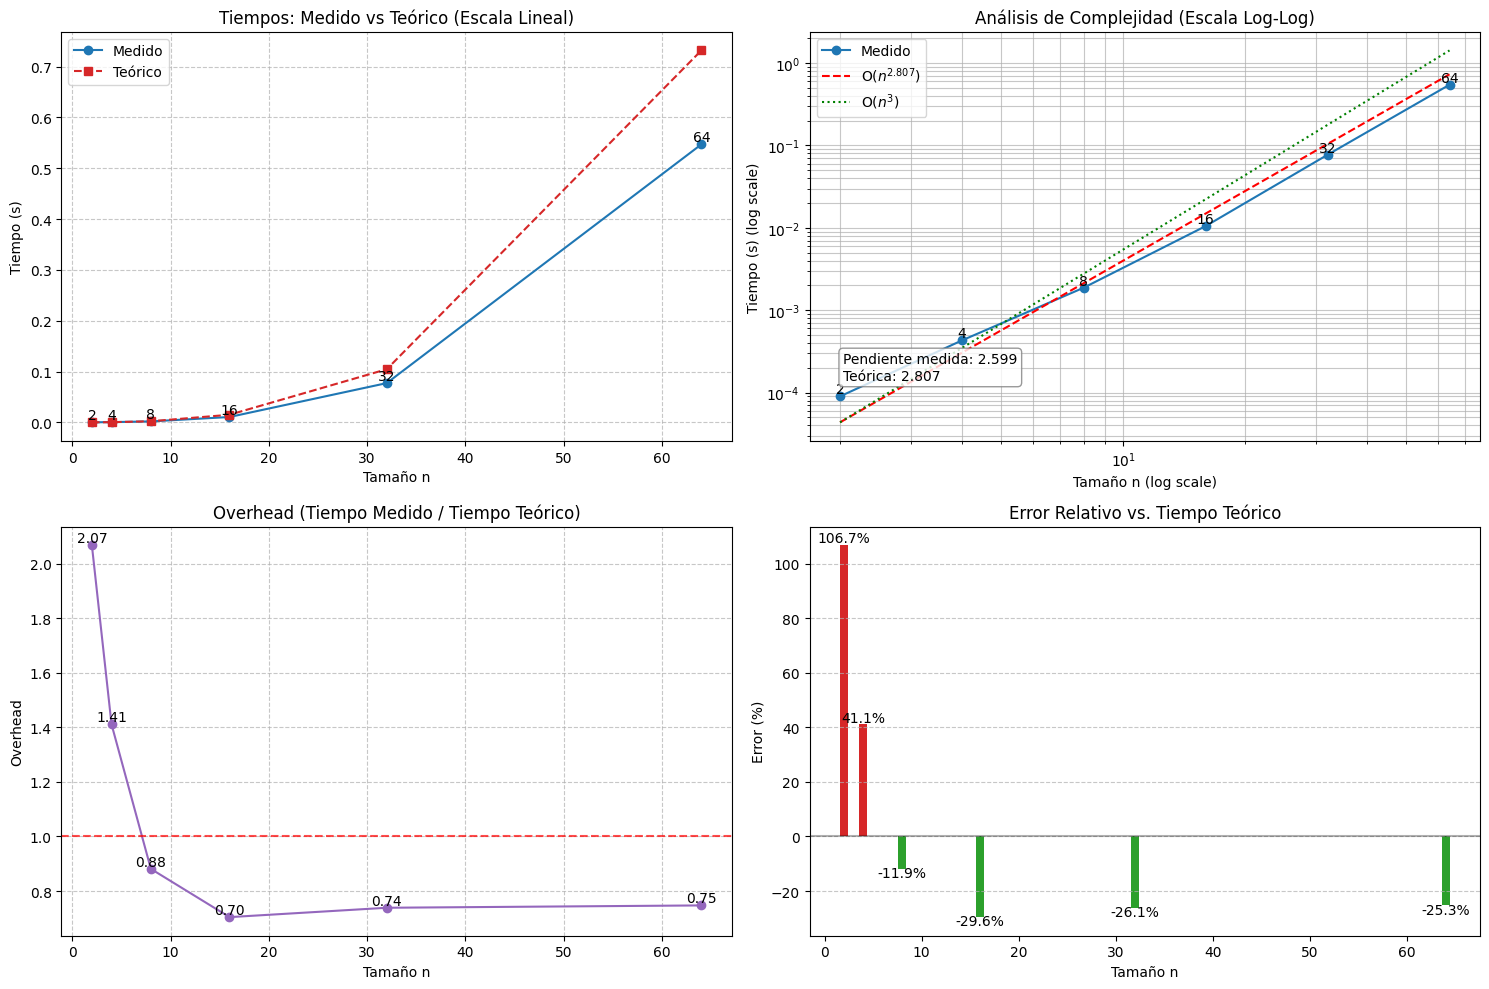


ANÁLISIS FINAL
- Constante de proporcionalidad (c): 6.22e-06
- Pendiente medida en escala log-log: 2.599
- Overhead promedio: 1.09x
- Tiempo teórico para n=1024: 1756.8245 s

✅ El algoritmo se acerca a su complejidad teórica para los tamaños medidos.


In [7]:
main()